# Plotting sliding window PCAs

After you've computed the sliding window PCAs with `compute_sliding_window_pca.ipynb` you can plot interactive versions (using plotly) or static versions (using matplotlib). The plots can result in very large files (e.g. 20Mb for the interactive 3RL plot, 12 Mb for the static svg).  

IT IS VERY IMPORTANT to select samples in the same way as was done to compute the PCAs (the last cell in access data) in order to correctly link it back to metadata.

### Imports

In [1]:
import malariagen_data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### Access data

In [2]:
#Here we read in data for funestus using the static cutoff site filter
af1 = malariagen_data.Af1(site_filters_analysis="sc_20220908")
af1

<MalariaGEN Af1 API client>
Storage URL             : gs://vo_afun_release_master_us_central1
Data releases available : 1.0
Results cache           : None
Cohorts analysis        : 20240515
Site filters analysis   : sc_20220908
Software version        : malariagen_data 10.0.0
Client location         : Iowa, United States (Google Cloud us-central1)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v10.0.0/Af1.html

In [3]:
#we read in the sample metadata for Af1.0 and
#we add some of the metadata contained in supplementary table 1 tab 2
extra_meta = pd.read_csv("../../metadata/supp1.csv")
extra_meta.rename(columns={'VBS_sample_id': 'sample_id'}, inplace=True)
#subset to useful columns and prevent duplicates
extra_meta = extra_meta[['sample_id',
       'geographic_cohort', 'geographic_cohort_colour',
       'geographic_cohort_shape', 'PCA_cohort', 'PCA_cohort_colour',
       'karyotype_3La', 'karyotype_3Ra', 'karyotype_3Rb', 'karyotype_2Ra',
       'karyotype_2Rh', 'karyotype_2Rt', 'mitochondrial_id', 'subset_1',
       'subset_2', 'subset_3']]
af1.add_extra_metadata(extra_meta)
meta = af1.sample_metadata(sample_sets='1.0')
meta.head()

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,...,karyotype_3La,karyotype_3Ra,karyotype_3Rb,karyotype_2Ra,karyotype_2Rh,karyotype_2Rt,mitochondrial_id,subset_1,subset_2,subset_3
0,VBS24195,1229-GH-A-GH01,Samuel Dadzie,Ghana,Dimabi,2017,8,9.420,-1.083,F,...,NaN,3R+/a,3Rb/b,2Ra/a,2R+/+,2R+/+,funestus-lineageI-clusterB,Y,Y,Y
1,VBS24196,1229-GH-A-GH02,Samuel Dadzie,Ghana,Gbullung,2017,7,9.488,-1.009,F,...,NaN,3Ra/a,3Rb/b,2Ra/a,2R+/+,2R+/+,funestus-lineageI-clusterB,Y,Y,Y
2,VBS24197,1229-GH-A-GH03,Samuel Dadzie,Ghana,Dimabi,2017,7,9.420,-1.083,F,...,NaN,3R+/a,3Rb/b,2Ra/a,2R+/+,2R+/+,funestus-lineageI-clusterB,Y,Y,Y
3,VBS24198,1229-GH-A-GH04,Samuel Dadzie,Ghana,Dimabi,2017,8,9.420,-1.083,F,...,NaN,3R+/a,3Rb/b,2Ra/a,2R+/+,2R+/+,funestus-lineageI-clusterB,Y,Y,Y
4,VBS24199,1229-GH-A-GH05,Samuel Dadzie,Ghana,Gupanarigu,2017,8,9.497,-0.952,F,...,NaN,3Ra/a,3Rb/b,2Ra/a,2R+/+,2R+/+,funestus-lineageI-clusterB,Y,Y,Y


In [4]:
#Run on all samples except the Ghana_Northern-Region geographic cohort
sample_idx = meta.loc[meta.geographic_cohort!='Ghana_Northern-Region'].index
#Subset meta to the same samples in the same order as was used in the computation
meta = meta.loc[sample_idx]

### Set up colours
meta has to contain a column with values used to group the samples and a column with colours for each of those samples. If you don't have particular colours you want to use, run the cell below to add up to 20 default colours for the unique values of the column you want to colour by.

In [5]:
colour_by = 'contributor'
colours = mpl.colormaps['tab20'].colors
colour_dict = dict(zip(meta.contributor.unique(), colours))
meta.loc[:,'plot_colour'] = meta.loc[:,'contributor'].map(colour_dict)

### Functions

In [17]:


def plot_interactive(
        data_dir, data_name, meta, 
        n_pc=None, display_exp_var=True,
        colour_by='geographic_cohort', colour_col='geographic_cohort_colour', 
        outdir=None, name=None, flips=None):
    
    '''
    data_dir: path to directory containing the data
    data_name: free text part in the name of datafiles 
    meta: the metadata dataframe with group and colour columns
    n_pc: number of pcs to display, default the number present in the datafile
    display_exp_var: boolean, whether to display the fraction of explained variance below the plot
    colour_by: column name used to group the samples
    colour_col: column name of the column containing colours for grouped samples
    outdir: where to output the file, default same as data_dir
    name: free text part of the name of the output file, default same as data_name,
    flips: list of tuples of where to flip the data in case of discontinuities. each tuple should be (pc, pos)
            where pc is the pc it applies to and everything to the right of pos (in bp) will be flipped
    '''
    
    #load data
    positions = np.load(f'{data_dir}/{data_name}_positions.npy')
    pc_values = np.load(f'{data_dir}/{data_name}_pc_values.npy')
    exp_var = np.load(f'{data_dir}/{data_name}_var_exp.npy')
    
    #set defaults
    if outdir is None:
        outdir = data_dir
    if name is None:
        name = data_name
    if n_pc is None:
        n_pc = pc_values.shape[0]
    
    flip = np.ones((n_pc, pc_values.shape[1]))
    #apply flips
    if flips is not None:
        for pc, bp in flips:
            flip[pc-1] *= np.where(positions[:,2]>=bp, -1, 1)
        

    #configure figure
    row_heights = [4 for i in np.arange(n_pc)]
    if display_exp_var:
        row_heights.append(1)
    fig = make_subplots(rows=len(row_heights), cols=1, row_heights=row_heights)
    
    #keep track of which cohorts have been added to the legend already
    cohorts_present = []
    
    #plot samples one by one
    for n, s in enumerate(meta.index):
        
        #if sample is from a cohort already present, don't add it to the legend
        if np.isin(meta.loc[s,colour_by], cohorts_present):
            fig.append_trace(go.Scatter(
                x=positions[:,2]/1000000, 
                y=pc_values[0,:,n]*flip[0],
                legendgroup=meta.loc[s,colour_by],
                name=meta.loc[s,'sample_id'],
                mode="lines",
                line=dict(color=meta.loc[s,colour_col], width=.4),
                showlegend=False),
                row=1, col=1)
            
        #if sample is from a cohort not present yet, add it to the legend    
        else:
            fig.append_trace(go.Scatter(
                x=positions[:,2]/1000000, 
                y=pc_values[0,:,n]*flip[0],
                legendgroup=meta.loc[s,colour_by],
                name=meta.loc[s,colour_by],
                mode="lines",
                line=dict(color=meta.loc[s,colour_col], width=.4)),
                row=1, col=1)
            cohorts_present.append(meta.loc[s,colour_by])
            
        #plot pc2 if necessary (uses same legend as pc1)
        if n_pc>1:
            fig.append_trace(go.Scatter(
                x=positions[:,2]/1000000, 
                y=pc_values[1,:,n]*flip[1],
                legendgroup=meta.loc[s,colour_by],
                name=meta.loc[s,'sample_id'],
                mode="lines",
                line=dict(color=meta.loc[s,colour_col], width=.4),
                showlegend=False),
                row=2, col=1)
            
    #plot explained variance if necessary
    if display_exp_var:
        fig.append_trace(go.Scatter(
            x=positions[:,2]/1000000,
            y=exp_var[0,:],
            mode="lines",
            line=dict(color='darkgrey', width=1),
            showlegend=False),
            row=len(row_heights), col=1)
        
        #plot explained variance for pc2 if necessary
        if n_pc>1:
            fig.append_trace(go.Scatter(
                x=positions[:,2]/1000000,
                y=exp_var[1,:],
                mode="lines",
                line=dict(color='lightgrey', width=1),
                showlegend=False),
                row=3, col=1)

        
    #set figure layout    
    fig.update_layout(
        title=f'Chromosome {name}',
        autosize=False,
        width=1300,
        height=100*sum(row_heights),
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        paper_bgcolor="White",
        plot_bgcolor="White",
    )
    
    fig.show()
    fig.write_html(f'{outdir}/PC_scan_{name}.html') 

In [26]:
#static version in matplotlib that is exportable as svg
def plot_static(
        data_dir, data_name, meta, 
        n_pc=None, display_exp_var=True,
        colour_by='geographic_cohort', colour_col='geographic_cohort_colour', 
        outdir=None, name=None, flips=None):
    
    #load data
    positions = np.load(f'{data_dir}/{data_name}_positions.npy')
    pc_values = np.load(f'{data_dir}/{data_name}_pc_values.npy')
    exp_var = np.load(f'{data_dir}/{data_name}_var_exp.npy')
    
    #set defaults
    if outdir is None:
        outdir = data_dir
    if name is None:
        name = data_name
    if n_pc is None:
        n_pc = pc_values.shape[0]
    
    flip = np.ones((n_pc, pc_values.shape[1]))
    #apply flips
    if flips is not None:
        for pc, bp in flips:
            flip[pc-1] *= np.where(positions[:,2]>=bp, -1, 1)
        

    #configure figure
    row_heights = [2 for i in np.arange(n_pc)]
    if display_exp_var:
        row_heights.append(1)
        
    positions = positions/1000000

    fig, ax = plt.subplots(len(row_heights), 1, figsize=(15,sum(row_heights)*1.5), 
                          gridspec_kw={'height_ratios': row_heights})
    
    #plot samples one by one
    for n, s in enumerate(meta.index):
        ax[0].plot(positions[:,2], pc_values[0,:,n], 
                c=meta.loc[s].geographic_cohort_colour,
                lw=.4)
        
        #plot pc2 if necessary
        if n_pc>1:
            ax[1].plot(positions[:,2], pc_values[1,:,n], 
                c=meta.loc[s].geographic_cohort_colour,
                lw=.4)
    
    #plot explained variance if necessary
    if display_exp_var:
        ax[len(row_heights)-1].plot(positions[:,2], exp_var[0,:],
                c='darkgrey')
        #plot explained variance for pc2 if necessary
        if n_pc>1:
            ax[len(row_heights)-1].plot(positions[:,2], exp_var[1,:],
                    c='lightgrey')
        #configure figure
        ax[len(row_heights)-1].set_ylim(ymin=0)
        
    ax[0].set_xlim((positions.min(), positions.max()))
    if n_pc>1:
        ax[1].set_xlim((positions.min(), positions.max()))
        
    for axx in ax:
        for spine in axx.spines.values():
            spine.set_visible(False)
            
            
    plt.tight_layout()
        
    plt.savefig(f'{outdir}/PC_scan_{name}.svg')

### Plot data

In [ ]:
plot_interactive('output', '3RL', meta)

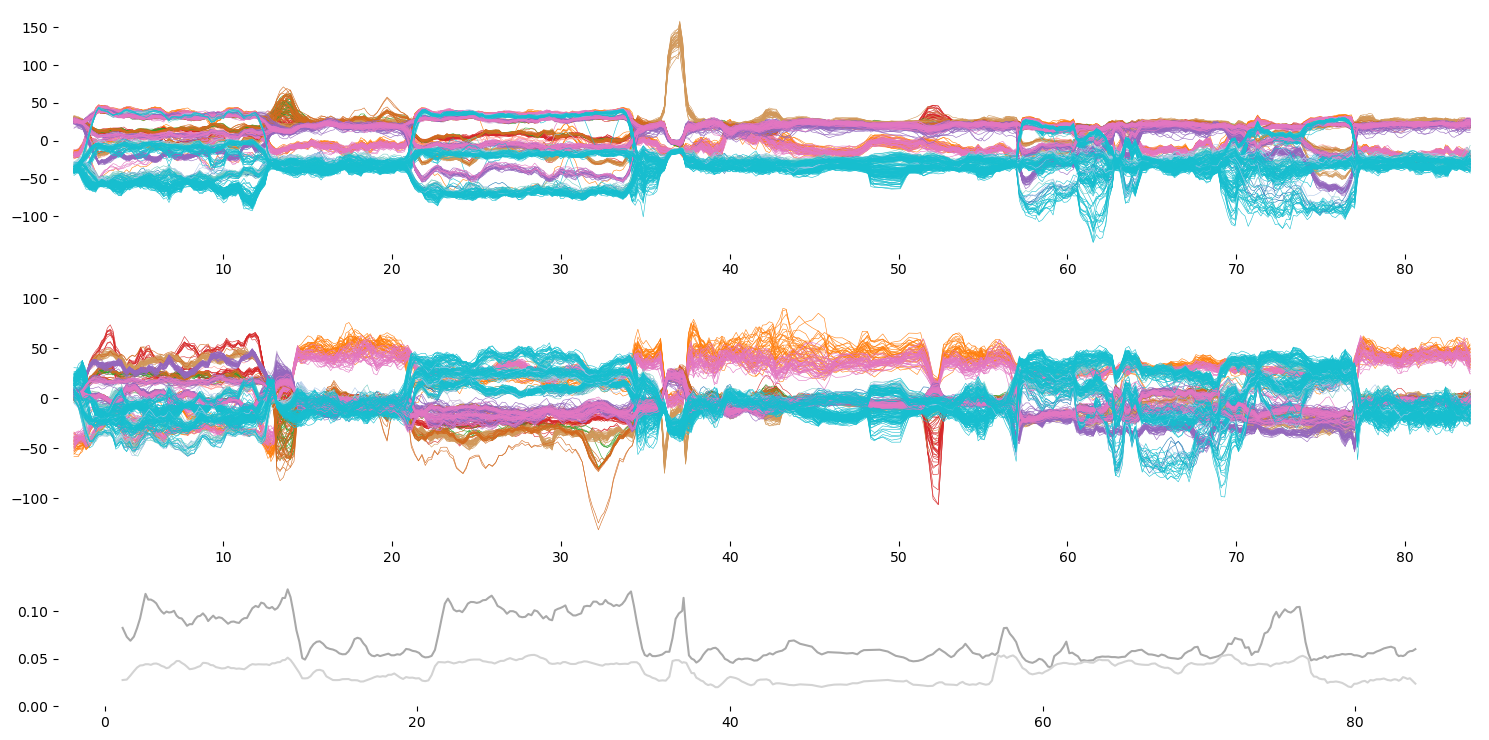

In [29]:
plot_static('output', '3RL', meta)